# Create Cell Cycle Binary_correlation_plot

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re

import cptac
import cptac.utils as u

import plot_utils as pu

In [165]:
'''
@Param plot_df:
     Dataframe with at least 2 columns of either p-value or correlation 
     values for two cancers. Can include up to 3 additional pathway columns. 
     Each pathway column represents a certain pathway or group of genes 
     specified with boolean variables (True = is in the group). Each pathway  
     column will become another scatterplot. 
       NOTE: Column names will be used as titles for the pathway plots.
     
@Param val:
    String. "corr": Correlation values
            "pval": p-values
    
@Param x_axis_col:
    String. Column label to plot on the x-axis.

@Param y_axis_col:
    String. Column label to plot on the y-axis.
    
@Param plot_pathways:
    List. Contains the column names containing pathway boolean values.
    
@Param hue_col:
    String. Column label to base hue color.

@Param hue_dict:
    Dictionary. A dictionary with values from the hue_col as keys 
    and chosen colors for the plot as values. 

@Param save_file_name:
    String. Optional to save the figure. The name of the file to
    save the figure to.

Returns:
    Scatterplots.

The wrap_ttest function will help with creating plot_df.
Both dataframes must have the gene included in the first column
(omics can be included) and the p-value. Wrap_ttest creates this
needed dataframe when its parameter return_all = True.

The path_df dataframe alows for multiple plots of specific gene groups
to be included. The first plot will always be all genes followed by one
plot for each column included in path_df. 
'''


def binary_val_plot(plot_df, val, x_axis_col, y_axis_col, title, pathway_cols = None, hue_col=None, 
                    color_dict = None, save_file_name=None):
    
    f = plt.figure(figsize=(12, 12))
    gs = f.add_gridspec(2, 2)
    sns.set(font_scale = 1.2)
        
    # Create Main plot
    all_pvals = f.add_subplot(gs[0, 0])
    if hue_col is not None:
        all_pvals = sns.scatterplot(x=x_axis_col, y=y_axis_col, data=plot_df,
                                   hue=hue_col, palette=color_dict) 
    else:
        all_pvals = sns.scatterplot(x=x_axis_col, y=y_axis_col, data=plot_df)
    all_pvals.set_title(title)    
    plt.xlabel(x_axis_col)
    plt.ylabel(y_axis_col)
    
    # Set scale of x and y axis
    if val == 'corr':
        axes = {'x_low': -1.5, 'x_high': 1.5, 'y_low': -1.5, 'y_high': 1.5}
    elif val == 'pval':
        all_pvals.set_xscale('log')
        all_pvals.set_yscale('log')
        axes = {'x_low': 1e-5, 'x_high': 1e0, 'y_low': 1e-5, 'y_high': 1e0}
    plt.xlim(axes['x_low'], axes['x_high']) 
    plt.ylim(axes['y_low'], axes['y_high'])
    
    
    # Create subplots for pathways/groups in path_df
    if pathway_cols is not None:
        i = 0
        j = 1
        for col in pathway_cols:
            bool_serries = plot_df[col]
            group_df = plot_df[bool_serries] # keep genes in pathway
            path = f.add_subplot(gs[i, j])
            path = sns.scatterplot(x=x_axis_col, y=y_axis_col, data=group_df, color = 'orange')
            if val == 'pval':
                path.set_xscale('log')
                path.set_yscale('log')
            plt.xlim(axes['x_low'], axes['x_high']) 
            plt.ylim(axes['y_low'], axes['y_high'])
            path.set_title(col) 
            plt.tight_layout()
            
            if i == j or i > j:
                j += 1
            elif i < j:
                i += 1 
                j -= 1
        
    if save_file_name is not None:
        fig.savefig(save_file_name+'.png')
        
    plt.show()
    plt.clf()
    plt.close()
    return 0

In [152]:
# Returns a dataframe with proteomics and mutation type

# all_prot: list of trans genes

def all_prot_format_df(cancer_object, all_prot, gene_in = 'PTEN'):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    
    if cancer_object.get_cancer_type() not in ('luad'):
        # Keep only tumor samples from proteomics
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot)
        # Reduce a multiindex 
        if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
            prot_and_mutations = cancer_object.reduce_multiindex(prot_and_mutations, levels_to_drop = 1)
        prot_and_mutations = prot_and_mutations[prot_and_mutations.Sample_Status == "Tumor"] # drop Normal samples

        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        mut_type = mut_type[['Mutation']] 
        prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
        merged = prot_df.join(mut_type)
        
        # Keep only Wildtype and deletion
        compare = ['Wildtype_Tumor','Deletion']
        get = merged['Mutation'].isin(compare)
        del_wt = merged[get]
    
    
    # Luad has no somatic mutations for PTEN which changes some things
    else: 
        # get_genotype_all_vars add cnv data under the column PTEN
        mut_type = mut_type.drop(columns= gene_in)
        # different code because no somatic mutation data for pten (can't join to somatic mutations)
        omics = cancer_object.join_omics_to_omics(df1_name = 'CNV', df2_name='proteomics',genes1= gene_in, 
            genes2= all_prot)
        omics = cancer_object.reduce_multiindex(omics, levels_to_drop = 1, flatten = True)
        omics = omics.drop(columns='PTEN_CNV')
        # Get only tumor samples
        p = cancer_object.get_proteomics(tissue_type='tumor')
        tumor_ids = list(p.index)
        get = omics.index.isin(tumor_ids)
        omics = omics[get]
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        merged = omics.join(mut_type) 
        # Keep only No_Mutation (wildtype) and deletion
        compare = ['No_Mutation','Deletion']
        get = merged['Mutation'].isin(compare)
        del_wt = merged[get]
        del_wt['Mutation'] = np.where(
            del_wt['Mutation'] == 'No_Mutation', 'Wildtype_Tumor', 'Deletion')

    return del_wt


# Select two cancers for the plot

In [153]:
en = cptac.Endometrial()
g = cptac.Gbm()

cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 2)


In [4]:
root = R'~\Github\WhenMutationsDontMatter\PTEN\Step_3_trans_effect\csv'
en_df = pd.read_csv(root+R'\endo_pval_medians.csv')
g_df = pd.read_csv(root+R'\gbm_pval_medians.csv')

# Calculate FDR-bh (lowest sig p-value = cutoff)

Gbm t-tests

In [5]:
gene = 'PTEN'
g_prot = g.get_proteomics()
g_prot_list = list(g_prot.columns)

g_del_wt = all_prot_format_df(g, g_prot_list, gene)
g_del_wt = g_del_wt.dropna(axis='columns', how='all')

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 72 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 394)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-01834 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 394)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 82 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 11)


In [6]:
cols = list(g_del_wt.columns[:-1])
print(len(cols))

# Get only sig genes
g_sig = u.wrap_ttest(g_del_wt, 'Mutation', cols, correction_method = 'fdr_bh')

# get_smallest p-value
cutoff_gbm = g_sig.P_Value[-1:]
cutoff_gbm

11141


C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\brittany henderson\Anaconda3\e

1886    0.008467
Name: P_Value, dtype: float64

Endo t-tests

In [7]:
gene = 'PTEN'
prot = en.get_proteomics()
p = list(prot.columns)

mut_type = en.get_genotype_all_vars(gene)

# merge cnv with genotype all mut type
prot_and_mutations = en.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'proteomics', omics_genes = p)
prot_and_mutations = prot_and_mutations[prot_and_mutations.Sample_Status == "Tumor"] # drop Normal samples
df = prot_and_mutations.iloc[:,:-4] #drop mutation, location cols
mut_type = mut_type[['Mutation']] 
merged = df.join(mut_type) # merge mutation col from function (includes cnv)

# Keep two values to compare
compare = ['Wildtype_Tumor','Nonsense_Mutation','Frame_Shift_Ins','Frame_Shift_Del']
get = merged['Mutation'].isin(compare)
trunc_wt = merged[get]
trunc_wt['Mutation'] = np.where(
                trunc_wt['Mutation'] == 'Wildtype_Tumor', 'Wildtype_Tumor', 'Truncation')
trunc_wt = trunc_wt.dropna(axis='columns',how='all')

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 20 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 394)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 69 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 9)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
cols = list(trunc_wt.columns[:-1])
print(len(cols))

# Get only sig sites
e_sig = u.wrap_ttest(trunc_wt, 'Mutation', cols, correction_method = 'fdr_bh')

# get_smallest p-value
cutoff_en = e_sig.P_Value[-1:]
cutoff_en

10993


401    0.001826
Name: P_Value, dtype: float64

# Create df with p-values for all genes in a pathway

In [10]:
# get a list of genes in a complete Pathway 
#all_dna_rep = 'DNA2 FEN1 LIG1 MCM2 MCM3 MCM4 MCM5 MCM6 MCM7 PCNA POLA1 POLA2 POLD1 POLD2 POLD3 POLD4 POLE POLE2 POLE3 POLE4 PRIM1 PRIM2 RFC1 RFC2 RFC3 RFC4 RFC5 RNASEH1 RNASEH2A RNASEH2B RNASEH2C RPA1 RPA2 RPA3 RPA4 SSBP1'
#all_dna_genes = all_dna_rep.split(' ')

In [11]:
 
cell_cycle = ('ANAPC1 ANAPC10 ANAPC11 ANAPC13 ANAPC2 ANAPC4 ANAPC5 ANAPC7 ATM ATR BUB1 BUB1B BUB3 CCNA1 CCNA2 CCNB1 '+
              'CCNB2 CCNB3 CCND1 CCND2 CCND3 CCNE1 CCNE2 CCNH CDC14A CDC14B CDC16 CDC20 CDC23 CDC25A CDC25B CDC25C '+
              'CDC26 CDC27 CDC45 CDC6 CDC7 CDK1 CDK2 CDK4 CDK6 CDK7 CDKN1A CDKN1B CDKN1C CDKN2A CDKN2B CDKN2C CDKN2D '+
              'CHEK1 CHEK2 CREBBP CUL1 DBF4 E2F1 E2F2 E2F3 E2F4 E2F5 EP300 ESPL1 FZR1 GADD45A GADD45B GADD45G GSK3B '+
              'HDAC1 HDAC2 MAD1L1 MAD2L1 MAD2L2 MCM2 MCM3 MCM4 MCM5 MCM6 MCM7 MDM2 MYC ORC1 ORC2 ORC3 ORC4 ORC5 ORC6 '+
              'PCNA PKMYT1 PLK1 PRKDC PTTG1 PTTG2 RAD21 RB1 RBL1 RBL2 RBX1 SFN SKP1 SKP2 SMAD2 SMAD3 SMAD4 SMC1A SMC1B '+
              'SMC3 STAG1 STAG2 TFDP1 TFDP2 TGFB1 TGFB2 TGFB3 TP53 TTK WEE1 WEE2 YWHAB YWHAE YWHAG YWHAH YWHAQ YWHAZ '+
              'ZBTB17')
cell_cycle = cell_cycle.split(' ')

In [13]:
# Merge dfs of both cancers and keep only genes in a complete pathway
merged = g_df.merge(en_df, on ='Proteomics', how='outer')
merged = merged.replace(regex=True,to_replace='_proteomics', value='')
dna_bool = merged.Proteomics.isin(cell_cycle)
df = merged[dna_bool]
df.head()

,Proteomics,Gbm_P_Value,Gbm_Median,En_P_Value,En_Median
41,PRKDC,0.000002,0.467360,0.020924,-0.1534
111,MCM6,0.000014,1.085407,0.009135,-0.6230
113,MCM4,0.000014,1.236484,0.015520,-0.6710
114,MAD2L1,0.000014,0.546914,0.775250,-0.0700
131,PCNA,0.000019,0.631486,0.012305,-0.2350


In [14]:
# Create pval only df for Color mapping
pval_df = df.drop(columns = ['Gbm_Median','En_Median'])
pval_df = pval_df.set_index('Proteomics')
pval_df.head()

,Gbm_P_Value,En_P_Value
Proteomics,,
PRKDC,0.000002,0.020924
MCM6,0.000014,0.009135
MCM4,0.000014,0.015520
MAD2L1,0.000014,0.775250
PCNA,0.000019,0.012305


# Create the color column based on significance in both cancers 

In [15]:
def Color(row):
    color = 'Not_sig'

    c1_cutoff = .008667 # lowest p-value for cancer 1
    c2_cutoff = 0.001826

    for item in row:
        if pd.isnull(item):
            continue
        if row['Gbm_P_Value'] <= c1_cutoff and row['En_P_Value'] <= c2_cutoff:
            color = 'Both_sig'
        elif row['Gbm_P_Value'] <= c1_cutoff:
            color = 'Gbm_sig'
        elif row['En_P_Value'] <= c2_cutoff:
            color = 'En_sig'
           
    return color

In [16]:
print('lowest p-value for Gbm:',cutoff_gbm, '\n')
print('lowest p-value for Endo:',cutoff_en)

lowest p-value for Gbm: 1886    0.008467
Name: P_Value, dtype: float64 

lowest p-value for Endo: 401    0.001826
Name: P_Value, dtype: float64


In [17]:
pval_df['color'] = pval_df.apply(Color, axis=1)
color = pval_df[['color']]
pval_df.loc[pval_df['color'] == 'Both_sig']


,Gbm_P_Value,En_P_Value,color
Proteomics,,,
BUB1B,0.006255,0.000701,Both_sig


# Format df for plot. Add color column and add pathway columns.

In [158]:
color_df = color.reset_index()
plot_df = df.merge(color_df, on='Proteomics')
#plot_df= plot_df.drop(columns=['Gbm_M','En_P_Value'])
plot_df.head()

,Proteomics,Gbm_P_Value,Gbm_Median,En_P_Value,En_Median,color
0,PRKDC,0.000002,0.467360,0.020924,-0.1534,Gbm_sig
1,MCM6,0.000014,1.085407,0.009135,-0.6230,Gbm_sig
2,MCM4,0.000014,1.236484,0.015520,-0.6710,Gbm_sig
3,MAD2L1,0.000014,0.546914,0.775250,-0.0700,Gbm_sig
4,PCNA,0.000019,0.631486,0.012305,-0.2350,Gbm_sig


In [159]:
# Create pathway columns

group = plot_df['Proteomics'].isin(['MCM2','MCM3','MCM4'])
group2 = plot_df['Proteomics'].isin(['MCM5','MCM6','MCM7'])
group3 = plot_df['Proteomics'].isin(['PCNA'])
gene_df = plot_df[['Proteomics']]

grp = group.to_frame().rename(columns={'Proteomics':'MCM_First'})
grp2 = group2.to_frame().rename(columns={'Proteomics':'MCM_Last'})
grp3 = group3.to_frame().rename(columns={'Proteomics':'PCNA'})

# MERGE
mcm = gene_df.join(grp)
mcm = mcm.join(grp2)
genes_mcm = mcm.join(grp3)
combined = plot_df.merge(genes_mcm,on='Proteomics')
combined.head()


,Proteomics,Gbm_P_Value,Gbm_Median,En_P_Value,En_Median,color,MCM_First,MCM_Last,PCNA
0,PRKDC,0.000002,0.467360,0.020924,-0.1534,Gbm_sig,False,False,False
1,MCM6,0.000014,1.085407,0.009135,-0.6230,Gbm_sig,False,True,False
2,MCM4,0.000014,1.236484,0.015520,-0.6710,Gbm_sig,True,False,False
3,MAD2L1,0.000014,0.546914,0.775250,-0.0700,Gbm_sig,False,False,False
4,PCNA,0.000019,0.631486,0.012305,-0.2350,Gbm_sig,False,False,True


In [160]:
# Create dictionary to map colors to values in the color column
hue_dict = {'Both_sig':'green',
            'En_sig':'yellow',
            'Gbm_sig': 'blue',
            'Not_sig': 'grey'}

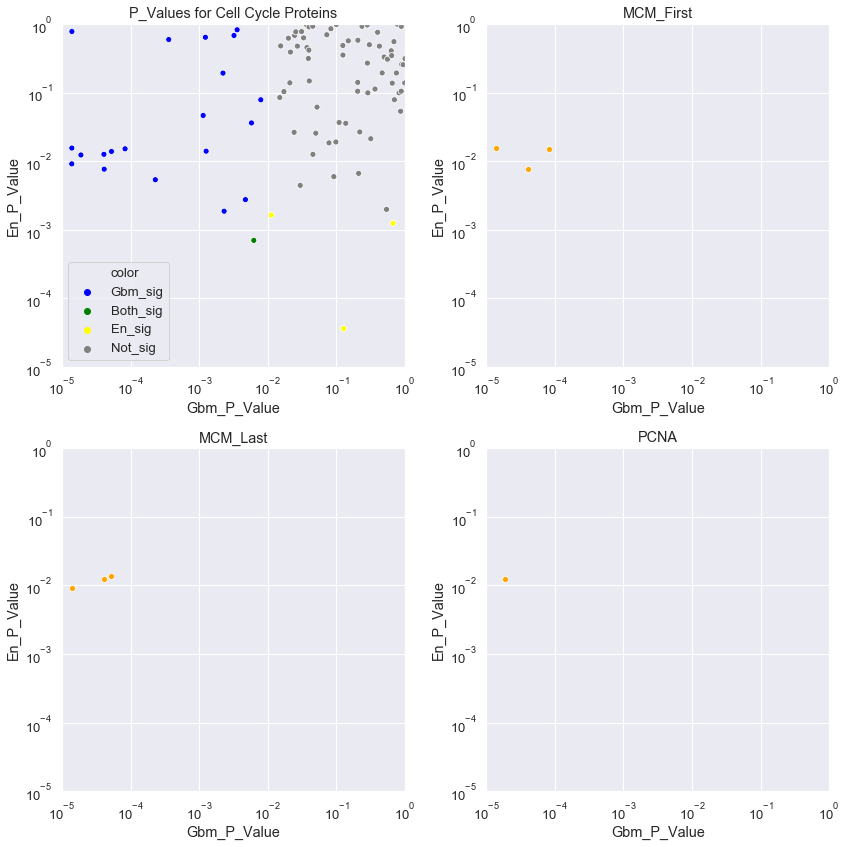

0

In [169]:
binary_val_plot(combined, 'pval', 'Gbm_P_Value', 'En_P_Value','P_Values for Cell Cycle Proteins', 
                ['MCM_First','MCM_Last','PCNA'], 'color', cd)

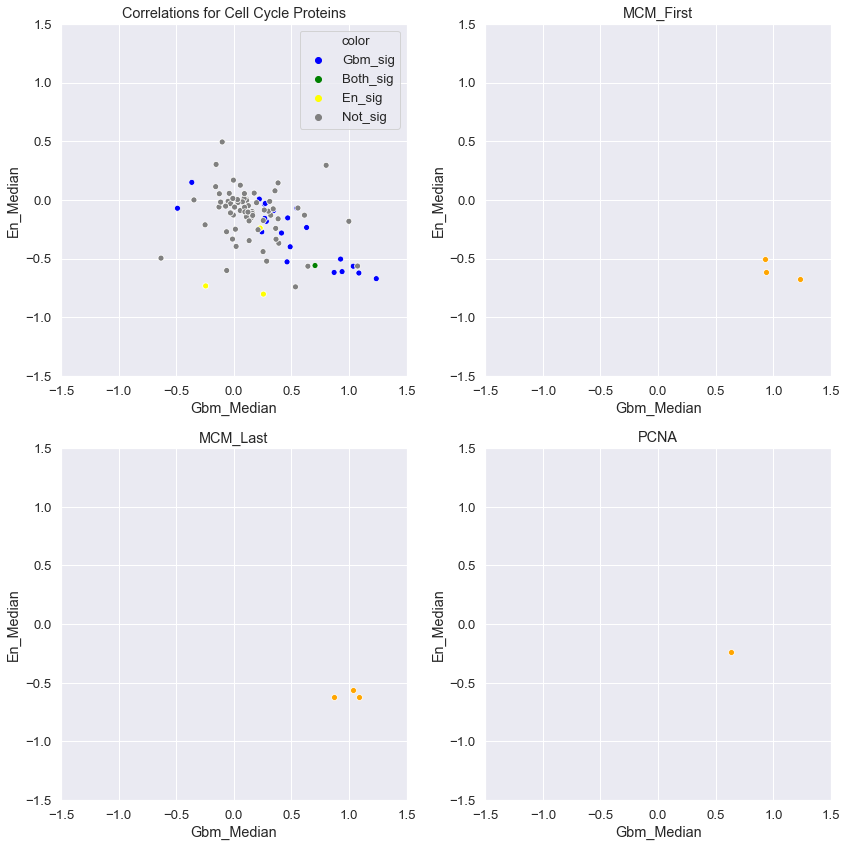

0

In [171]:
binary_val_plot(combined, 'corr', 'Gbm_Median', 'En_Median','Correlations for Cell Cycle Proteins', 
                ['MCM_First','MCM_Last','PCNA'], 'color', cd)